# Pitchers — CSW% Trends & Contact Quality

This notebook shows two pitcher-facing analyses using **season-level** features from this repo:

1. **CSW% trends across seasons** for top-BF pitchers (who faced the most batters).  
2. **Contact quality** scatter: **GB% vs EV allowed**, sized by BF, color-coded by season, with an option to label top pitchers.

It looks for `data/processed/pitchers_features.csv` first, and will fall back to `sample_data/pitchers_features_sample.csv` if needed.


In [1]:
# Setup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROC_DIR = Path('data/processed')
SAMPLE_DIR = Path('sample_data')

plt.rcParams['figure.figsize'] = (10, 5)

## Load season-level pitcher features

In [ ]:
pf_path = PROC_DIR / 'pitchers_features.csv'
if not pf_path.exists():
    alt = SAMPLE_DIR / 'pitchers_features_sample.csv'
    pf_path = alt if alt.exists() else None

if pf_path and pf_path.exists():
    pit = pd.read_csv(pf_path)
else:
    pit = pd.DataFrame()
    
# Clean types
if 'season' in pit.columns:
    pit['season'] = pd.to_numeric(pit['season'], errors='coerce').astype('Int64')
for c in ['bf','csw_rate','k_rate','bb_rate','gb_rate','ev_allowed']:
    if c in pit.columns:
        pit[c] = pd.to_numeric(pit[c], errors='coerce')

print('Pitchers features:', pit.shape)
display(pit.head(3))

Pitchers features: (2435, 9)


,player_id,player_name,season,bf,csw_rate,k_rate,bb_rate,gb_rate,ev_allowed
0,664849,"Young, Danny",2022,32.0,0.417808,0.343750,0.062500,0.517241,79.120000
1,621242,"Díaz, Edwin",2022,242.0,0.414538,0.520661,0.090909,0.509259,79.886975
2,458677,"Wilson, Justin",2022,13.0,0.407407,0.846154,0.000000,0.500000,81.833333


## CSW% trends across seasons

We draw a line for each of the **top N pitchers by BF** (batters faced), showing their CSW% across available seasons.


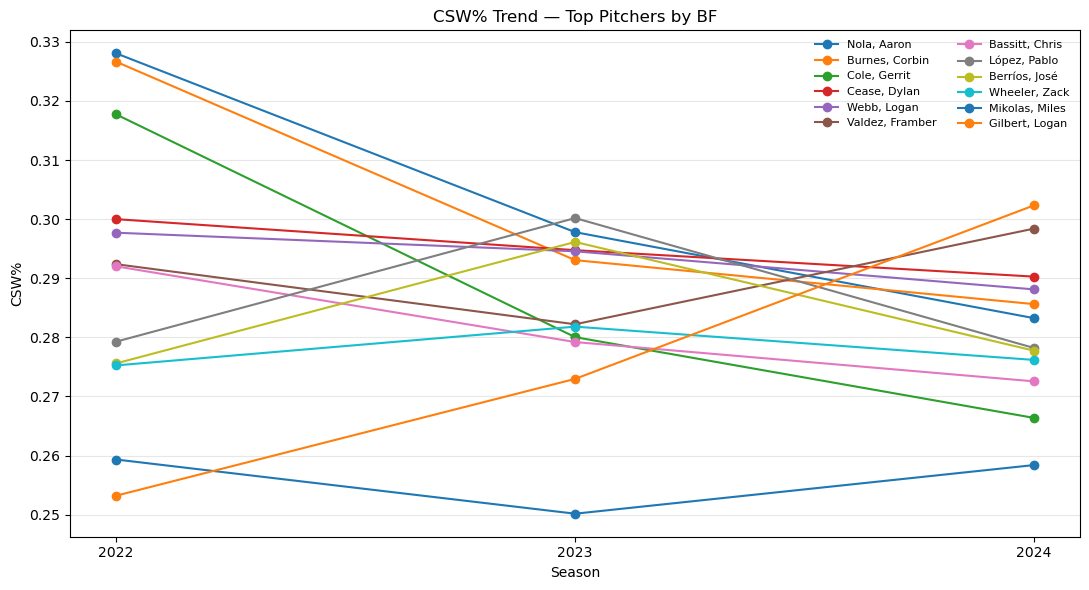

In [8]:
if pit.empty or 'csw_rate' not in pit.columns:
    raise SystemExit('No pitcher features found. Run the pipeline to create data/processed/pitchers_features.csv.')

# Choose top N by BF (aggregate across seasons)
agg = (pit.groupby(['player_id','player_name'])['bf']
          .sum()
          .sort_values(ascending=False)
          .reset_index())
TOP_N = 12
top_ids = set(agg.head(TOP_N)['player_id'])

sub = pit[pit['player_id'].isin(top_ids)].copy()
sub = sub.dropna(subset=['season','csw_rate'])
sub['season'] = sub['season'].astype(int)

players = sub[['player_id','player_name']].drop_duplicates()

# Plot lines
plt.figure(figsize=(11, 6))
for pid, pname in players.itertuples(index=False):
    s = sub[sub['player_id']==pid].sort_values('season')
    plt.plot(s['season'], s['csw_rate'], marker='o', label=str(pname))
plt.title('CSW% Trend — Top Pitchers by BF')
plt.xlabel('Season')
plt.ylabel('CSW%')
plt.xticks(sorted(sub['season'].unique()))
plt.grid(True, axis='y', alpha=0.3)
plt.legend(ncol=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

## Contact quality: GB% vs EV allowed

Lower EV allowed and higher GB% are generally positive indicators for contact management.  
We size points by BF (more innings/workload) and color by season.


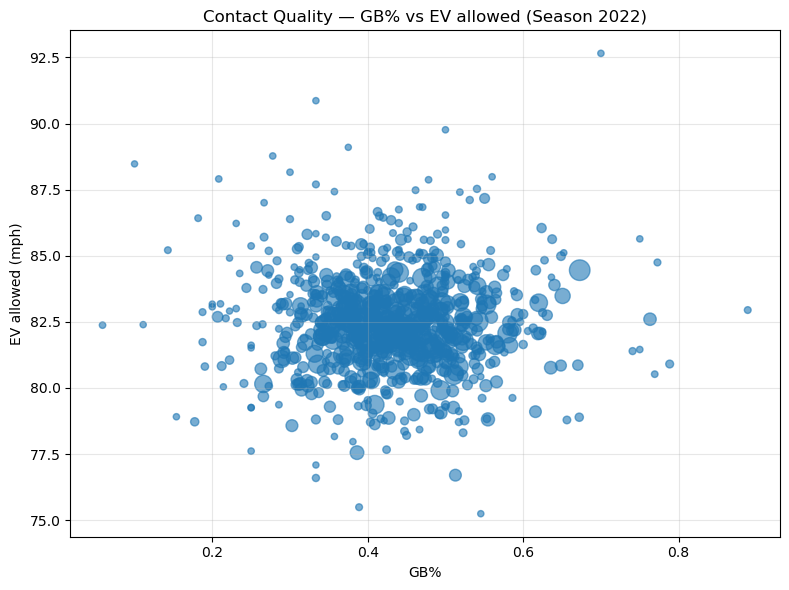

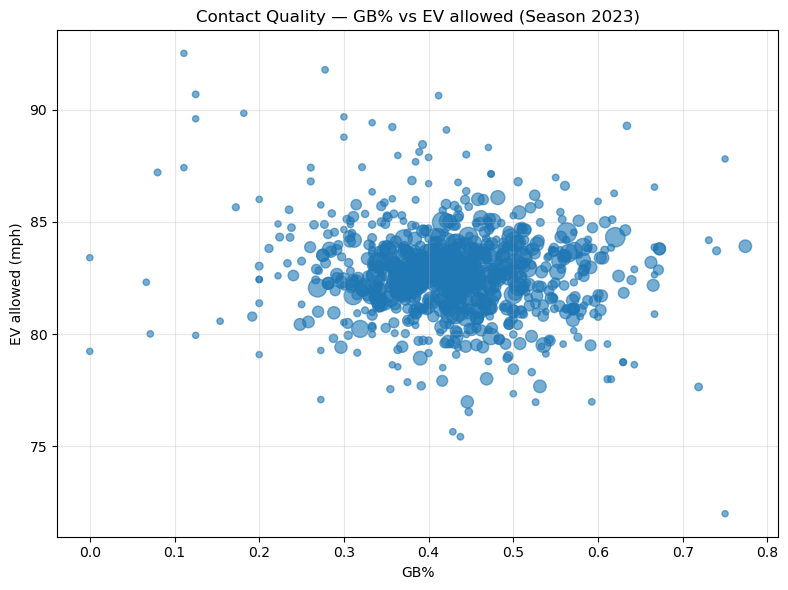

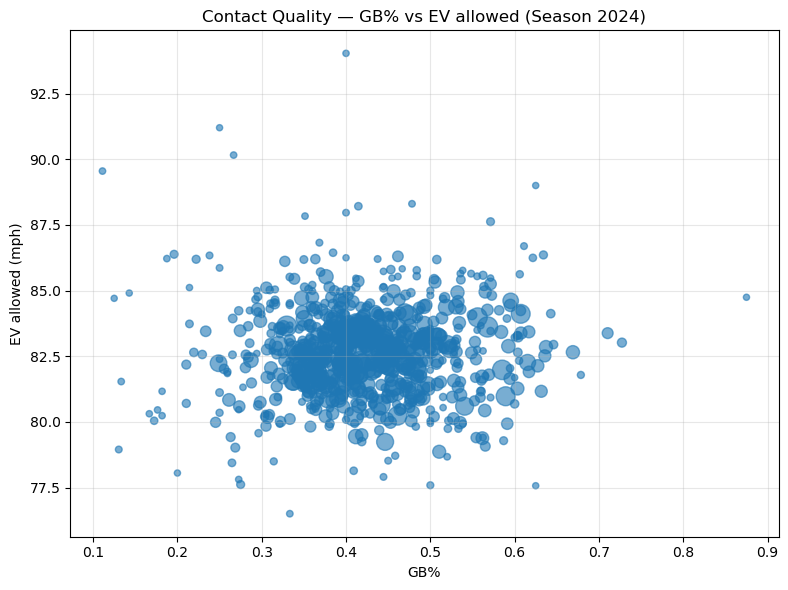

In [9]:
# Prepare scatter data
scat = pit.dropna(subset=['gb_rate','ev_allowed','bf','season']).copy()
scat['season'] = scat['season'].astype(int)

# Basic scatter per season (one figure per season for clarity)
for yr in sorted(scat['season'].unique()):
    d = scat[scat['season']==yr]
    plt.figure(figsize=(8, 6))
    sizes = (d['bf'] - d['bf'].min()) / max(1e-9, (d['bf'].max() - d['bf'].min())) * 200 + 20
    plt.scatter(d['gb_rate'], d['ev_allowed'], s=sizes, alpha=0.6)
    plt.title(f'Contact Quality — GB% vs EV allowed (Season {yr})')
    plt.xlabel('GB%')
    plt.ylabel('EV allowed (mph)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Optional: label the top pitchers (by BF) within a season

Labels can clutter; we annotate only the top-K by BF per season for quick identification.


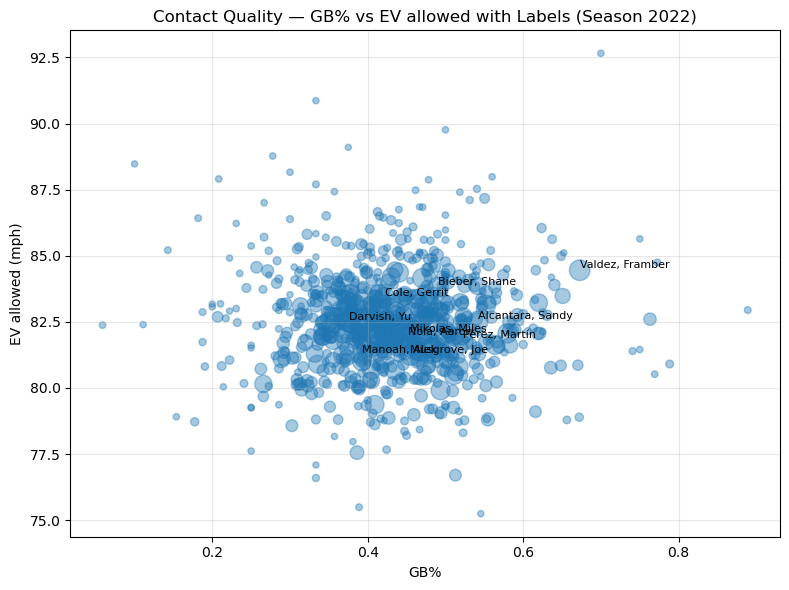

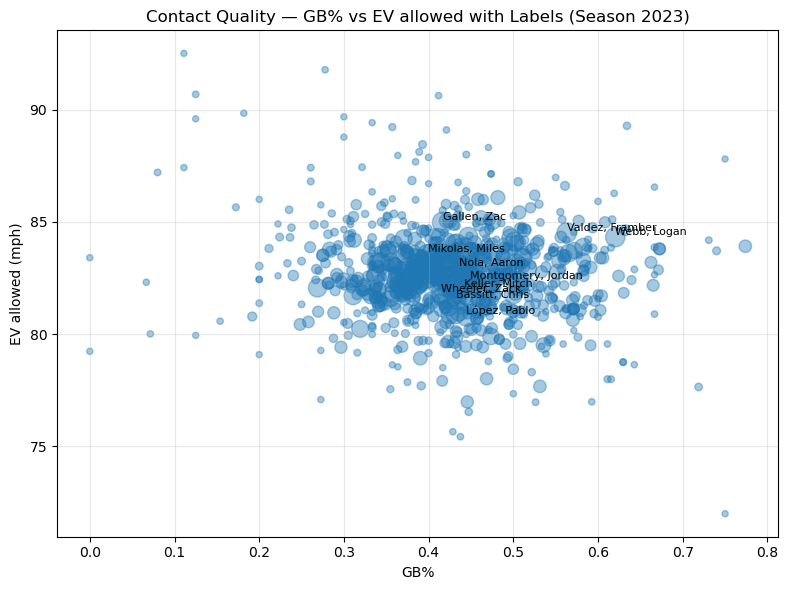

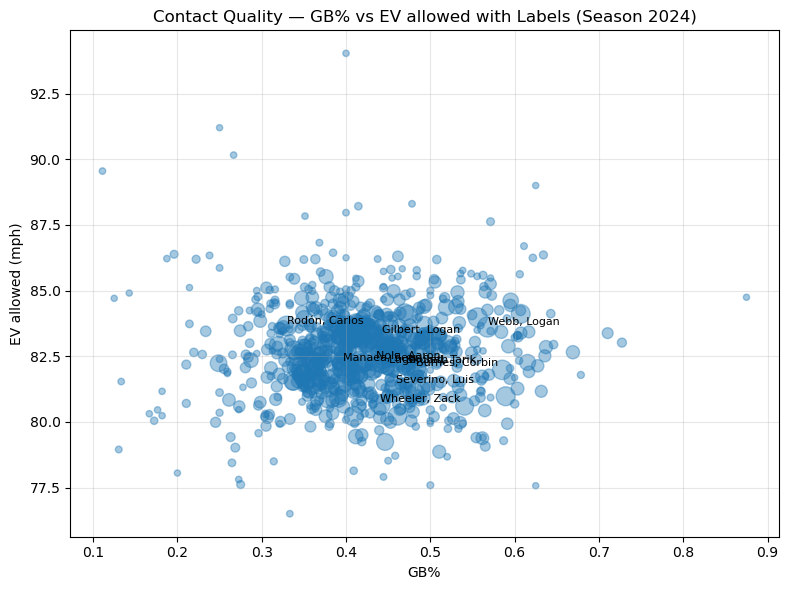

In [10]:
TOP_K_LABEL = 10
for yr in sorted(scat['season'].unique()):
    d = scat[scat['season']==yr].copy()
    d = d.sort_values('bf', ascending=False)
    topk = d.head(TOP_K_LABEL)

    plt.figure(figsize=(8, 6))
    sizes = (d['bf'] - d['bf'].min()) / max(1e-9, (d['bf'].max() - d['bf'].min())) * 200 + 20
    plt.scatter(d['gb_rate'], d['ev_allowed'], s=sizes, alpha=0.4)
    # annotate top-k
    for _, row in topk.iterrows():
        plt.text(row['gb_rate'], row['ev_allowed'], str(row.get('player_name','')), fontsize=8, ha='left', va='bottom')
    plt.title(f'Contact Quality — GB% vs EV allowed with Labels (Season {yr})')
    plt.xlabel('GB%')
    plt.ylabel('EV allowed (mph)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

> **Notes**
"
"- If you want team-specific plots (e.g., only Yankees), filter `pit` to a team column once you add it in your feature builder.
"
"- To analyze **per-pitch** CSW% trends (rolling), compute from raw Statcast with a pitch-level groupby and a rolling window."
